In [2]:
# Taken from https://github.com/GunhoChoi/AnoGAN-Pytorch

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0" # set gpu number to use

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

# Постановка задачи

Задача поиска аномалий - находить объекты, отличные от нормальных данных

**Примеры:** поиск сбоев, атак, ботов и другого аномального поведения или объектов

Как правило, ***основное отличие задачи поиска аномалий от задачи бинарной классификации*** заключается в том, что ***аномалий*** в выборке ***намного меньше или нет вообще***!

В связи с этим, большинство алгоритмов поиска аномалий, таких как OneClass-SVM и Isolation Forest, основываются на ***гипотезе о компактности***, когда нормальные объекты образуют некоторый кластер или группу кластеров (см. рис. ниже)
![](https://developer.mindsphere.io/apis/analytics-anomalydetection/images/DBSCAN.png)


Для экспериментов будем использовать датасет рукописных цифр MNIST

In [6]:
batch_size = 1000 # по какому количеству объектов выборки будем оценивать градиент 
learning_rate = 0.0002 # скорость обучения (шаг оптимизатора)
num_gpus = 1
anomaly_digit = 0 # какую цифру примем за аномалию

In [7]:
# Зададим обучающую и тестовую выборки в PyTorch

mnist_train = dset.MNIST("../../../data/", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)

mnist_test = dset.MNIST("../../../data/", train=False, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             transforms.Normalize([0.5], [0.5]),
                        ]),
                        target_transform=None,
                        download=True)


train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)
# DataLoader - вспомогательный класс PyTorch, который разбивает данные на батчи

0it [00:00, ?it/s]

9920512it [00:02, 3366421.51it/s]                             


Extracting ../../../data/MNIST/raw/train-images-idx3-ubyte.gz to ../../../data/MNIST/raw


32768it [00:00, 188545.54it/s]           
0it [00:00, ?it/s]

Extracting ../../../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../../../data/MNIST/raw


1654784it [00:01, 1188724.63it/s]                             
8192it [00:00, 81841.64it/s]


Extracting ../../../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../../data/MNIST/raw
Extracting ../../../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../../data/MNIST/raw
Processing...
Done!


In [11]:
next(iter(train_loader))[0].shape

torch.Size([1000, 1, 28, 28])

Label: 5


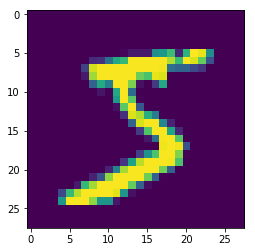

In [12]:
img, label = mnist_train[0] # первый элемент обучающей выборки
print(f'Label: {label}')
plt.imshow(img[0,:,:])

# Baseline
В качестве бейслайна попробуем обучить бинарный классификатор (аномалия/не аномалия) в условиях малого количества аномалий

## Задание 1
Обучите бинарный классификатор для поиска аномалий. Посмотрите на финальный ROC AUC 

In [6]:
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F

class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(192, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
model = AlexNet(num_classes=1)

criterion = nn.BCEWithLogitsLoss() # бинарная кросс-энтропия 
opt = torch.optim.Adam(model.parameters(), lr=learning_rate,betas=(0.5,0.999)) # оптимизатор

num_anomalies = 50

def one_hot(batch, depth):
    ones = torch.sparse.torch.eye(depth)
    return ones.index_select(0,batch)

epoch = 50 # сколько циклов обучения (сколько раз прогоним всю обучаюшую выборку в процессе обучения)

for i in range(epoch):
    used_anomalies = 0
    for j,(image,label) in enumerate(train_loader):
        opt.zero_grad() # удалим градиенты, посчитанные на предыдущем батче
        output = model(image)
        if used_anomalies < num_anomalies:
            used_anomalies += (label == anomaly_digit).sum()
            mask = (label >= 0)
        else:
            mask = label != anomaly_digit
            output = model(image)
        loss = criterion(output[mask], one_hot((label == anomaly_digit).long()[mask], 2))
        loss.backward()
        roc_auc = roc_auc_score((label==anomaly_digit).long().detach().cpu().numpy(), 
                                F.softmax(output, dim=1).detach().cpu().numpy()[:, 1]                                )
        opt.step()
    print(f'Epoch: {i}\t Loss: {loss.item()} ROC AUC: {roc_auc}')

Epoch: 0	 Loss: 1.102760052162921e-05 ROC AUC: 0.3410222222222223


KeyboardInterrupt: 

# AnoGAN

Основная идея [AnoGAN](https://arxiv.org/abs/1703.05921) - находить аномалии на основе расстояния до ближайшего соседа в пространстве латентных переменных. Алгоритм состоит из двух этапов:
1. На первом этапе обучается дискриминатор и генератор в стандартном режиме на нормальных объектах. При этом предполается, что генератор выучивает некоторое преобразование из латентного многообразия Z в пространство нормальных объектов
2. На втором этапе для каждого нового объекта считается расстояние до латентного многообразия, в котором сконцентрированы нормальные объекты. Те объекты, расстояние от которых до многообразия слишком большое, принимаются за аномалии

![](https://i.ibb.co/ZmzwMfS/image.png)

# AnoGAN. Этап 1. Обучение генератора на нормальных объектах

In [13]:
!nvidia-smi

Fri Nov  8 12:36:35 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.183      Driver Version: 384.183      CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000C93:00:00.0 Off |                    0 |
| N/A   48C    P0    72W / 149W |  10632MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00002BD8:00:00.0 Off |                    0 |
| N/A   65C    P0    61W / 149W |  11337MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [7]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
             nn.Linear(100,7*7*512),
             nn.BatchNorm1d(7*7*512),
             nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(512,256,3,2,1,1),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(256,128,3,1,1),
                        nn.BatchNorm2d(128),    
                        nn.LeakyReLU(),
            )
        self.layer3 = nn.Sequential(
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.BatchNorm2d(64),    
                        nn.LeakyReLU(),
                        nn.ConvTranspose2d(64,1,3,2,1,1),
                        nn.Tanh()
            )

    def forward(self,z):
        out = self.layer1(z)
        out = out.view(out.size()[0],512,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        return out

In [8]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1,8,3,padding=1),   # batch x 16 x 28 x 28
                        nn.BatchNorm2d(8),    
                        nn.LeakyReLU(),
                        nn.Conv2d(8,16,3,stride=2,padding=1),  # batch x 32 x 28 x 28
                        nn.BatchNorm2d(16),    
                        nn.LeakyReLU(),
                        #('max1',nn.MaxPool2d(2,2))   # batch x 32 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(16,32,3,stride=2,padding=1),  # batch x 64 x 14 x 14
                        nn.BatchNorm2d(32),
                        nn.LeakyReLU(),
                        #nn.MaxPool2d(2,2),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 128 x 7 x 7
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU()
        )
        self.fc = nn.Sequential(
                        nn.Linear(64*7*7,1),
                        nn.Sigmoid()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size()[0], -1)
        feature = out
        out = self.fc(out)
        return out,feature

In [9]:
# Put class objects on Multiple GPUs using 
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 
# along with .cuda()

generator = nn.DataParallel(Generator()).cuda()
discriminator = nn.DataParallel(Discriminator()).cuda()

## Задание 2
Обучите GAN любым удобным вам способом

**Внимание:** обучайте GAN только на **нормальных** объектах (цифрах)!

In [10]:
# loss function, optimizers, and labels for training

loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr= 5*learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(2):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

In [11]:
# model restore if any

try:
    generator.load_state_dict(torch.load('./saved_model/generator.pkl'))
    discriminator.load_state_dict(torch.load('./saved_model/discriminator.pkl'))
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass



--------model restored--------



/home/aryzhikov/data/envs/tf_old/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/aryzhikov/data/envs/tf_old/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


0th iteration gen_loss: 0.22319592535495758 dis_loss: 0.43591898679733276
0th iteration gen_loss: 0.3476751148700714 dis_loss: 0.46093690395355225


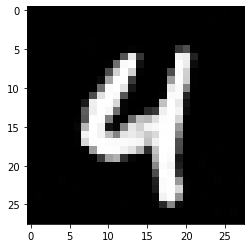

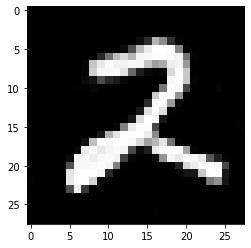

In [12]:
# train
epoch = 1 # сколько циклов обучения (сколько раз прогоним всю обучаюшую выборку в процессе обучения)

for i in range(epoch):
    for j,(image,label) in enumerate(train_loader):
        image = Variable(image).cuda()
        
        image = image[label != anomaly_digit] # оставляем для обучения только нормальные объекты
        label = label[label != anomaly_digit] # оставляем для обучения только нормальные объекты
        
        batch_size = image.shape[0]
        
        ones_label = Variable(torch.ones(batch_size,1)).cuda()
        zeros_label = Variable(torch.zeros(batch_size,1)).cuda()

        
        # generator
        gen_optim.zero_grad()
        
        z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label)) # fake classified as real
        gen_loss.backward(retain_graph=True)
        gen_optim.step()
    
        # discriminator
        dis_optim.zero_grad()
        
        z = Variable(init.normal(torch.Tensor(batch_size,100),mean=0,std=0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake,_ = discriminator.forward(gen_fake)
        
        dis_real,_ = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real,ones_label))
        dis_loss.backward()
        dis_optim.step()
    
        # model save
        if j % 50 == 0:
            #print(gen_loss,dis_loss)
            torch.save(generator.state_dict(),'./saved_model/generator.pkl')
            torch.save(discriminator.state_dict(),'./saved_model/discriminator.pkl')


            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            v_utils.save_image(gen_fake.data[0:25],"./result/gen_{}_{}.png".format(i,j), nrow=5)
            
    image_check(gen_fake.cpu())

## AnoGAN. Этап 2. Подсчёт расстояния до нормальных объектов и подбор 

## Задание 3
Реализуйте расстояние до аномалий согласно формуле, предложенной в [статье](https://arxiv.org/abs/1703.05921):
$$L(x,G_z)=(1-\lambda)|x-G_z| + \lambda|D(x)-D(G_z)|$$

In [13]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x,G_z,Lambda=0.1): # расстояние до аномалии x до ближайшего соседа G_z
    
    
    ,x_feature = discriminator(x)
    _,G_z_feature = discriminator(G_z)
    
    residual_loss = torch.sum(torch.abs(x-G_z), dim=[1,2,3])
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature), 1)
    
    total_loss = (1-Lambda)*residual_loss + Lambda*discrimination_loss
    return total_loss

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

start_idx = 64
train_size = 500


train_data_mnist = mnist_train.__dict__['data'][start_idx:start_idx+train_size]
train_label_mnist = mnist_train.__dict__['targets'][start_idx:start_idx+train_size] == anomaly_digit # 0 - нормальный объект, 1 - аномалия
train_data_mnist = train_data_mnist.view(train_size,1,28,28).type_as(torch.FloatTensor())
train_data_mnist.size()

torch.Size([500, 1, 28, 28])

In [15]:
generator = nn.DataParallel(Generator(),device_ids=[0])
discriminator = nn.DataParallel(Discriminator(),device_ids=[0])

#generator,discriminator

In [16]:
# !rm -rf saved_model/

In [17]:
# model restore if any

try:
    generator.load_state_dict(torch.load('./saved_model/generator.pkl'))
    discriminator.load_state_dict(torch.load('./saved_model/discriminator.pkl'))

    print("\n--------model restored--------\n")

except:
    print("\n--------model not restored--------\n")
    pass




--------model restored--------



In [24]:
z = Variable(init.normal(torch.zeros(train_size,100),mean=0,std=0.1),requires_grad=True) # для каждого объекта берём случайный нормальный объект в латентном пространстве в качестве начального соседа
z_optimizer = torch.optim.Adam([z],lr=1e-4)

gen_fake = generator(z.cuda())
loss = Anomaly_score(Variable(train_data_mnist).cuda(),gen_fake) # расстояние до нормального соседа. Путём минимизации этого расстояния будем находить расстояние до ближайшего соседа
print(loss.shape)
print(loss.mean())

/home/aryzhikov/data/envs/tf_old/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """Entry point for launching an IPython kernel.


torch.Size([500])
tensor(23418.8535, device='cuda:0', grad_fn=<MeanBackward0>)


## Задание 4
Используя оптимизатор выше, найдите ближайших соседей z для выборки train_data_mnist. Посмотрите, как по мере обучения меняется расстояние и ROC AUC. Сравните результат с baseline. Стало ли лучше?

In [19]:
for i in range(5000):
    gen_fake = generator(z.cuda())
    dist = Anomaly_score(Variable(train_data_mnist).cuda(),gen_fake,Lambda=0.01)
    dist.mean().backward() # минимизируем расстояние до нормального соседа
    z_optimizer.step() # обновляем ближайшего нормального соседа (z) для каждого объекта 
    roc_auc = roc_auc_score(train_label_mnist.detach().cpu().numpy(), 
                            dist.detach().cpu().numpy())
    if i%100==0:
        print(f'Dist: {dist.mean().cpu().data} ROC AUC: {roc_auc}')
        '''
        target = test_data_mnist[1,0,:,:].numpy()
        plt.imshow(target,cmap="gray")
        plt.show()
        
        img=gen_fake.cpu().data[1,0,:,:].numpy()
        plt.imshow(img,cmap='gray')
        plt.show()
        '''

Dist: 25619.994140625 ROC AUC: 0.8315818584070798


KeyboardInterrupt: 

## Задание 5
Посмотрим на ближайших соседей

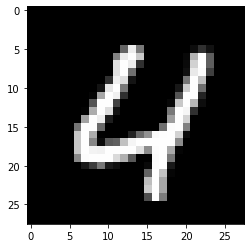

real data


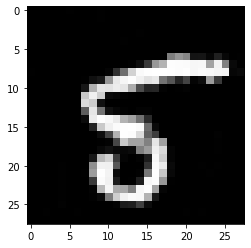

nearest neighbour

------------------------------------



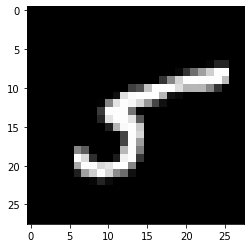

real data


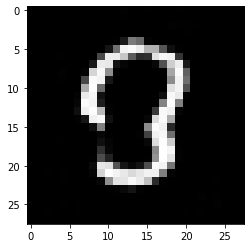

nearest neighbour

------------------------------------



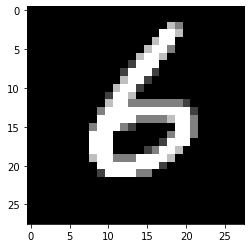

real data


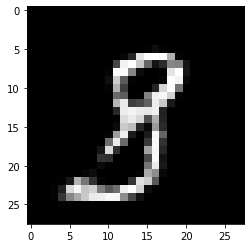

nearest neighbour

------------------------------------



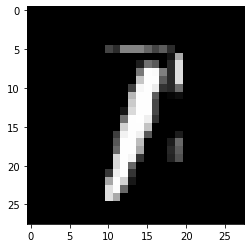

real data


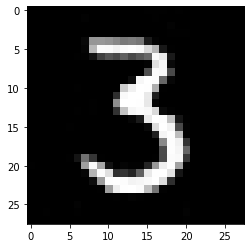

nearest neighbour

------------------------------------



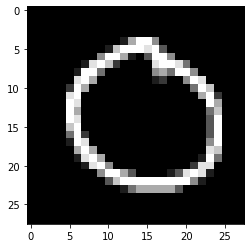

real data


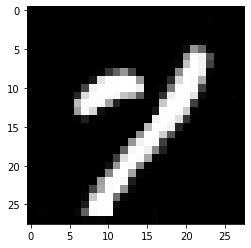

nearest neighbour

------------------------------------



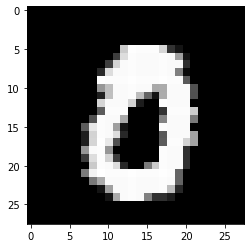

real data


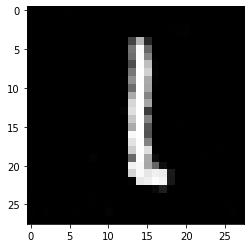

nearest neighbour

------------------------------------



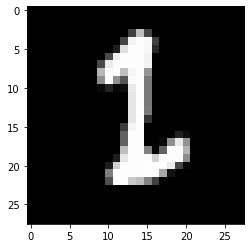

real data


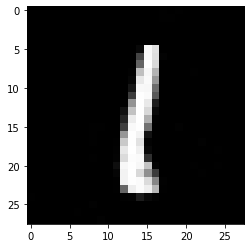

nearest neighbour

------------------------------------



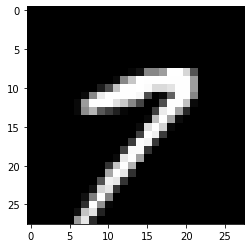

real data


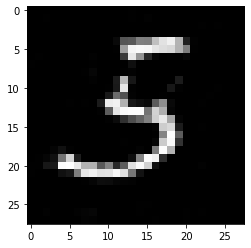

nearest neighbour

------------------------------------



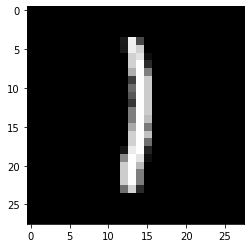

real data


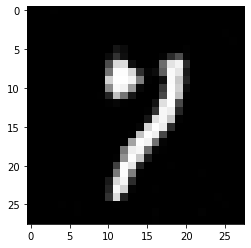

nearest neighbour

------------------------------------



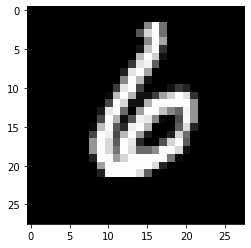

real data


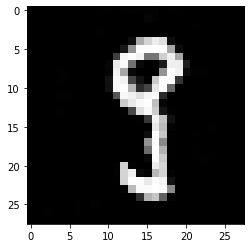

nearest neighbour

------------------------------------



In [22]:
for idx in range(10):
    target = train_data_mnist[idx,0,:,:].numpy()
    plt.imshow(target,cmap="gray")
    plt.show()
    print("real data")

    img=gen_fake.cpu().data[idx,0,:,:].numpy()
    plt.imshow(img,cmap='gray')
    plt.show()
    print("nearest neighbour")
    print("\n------------------------------------\n")

## Задание 6
Построим распределение расстояний для нормальных и аномальных объектов.
Что можно сказать, глядя на это распределение?

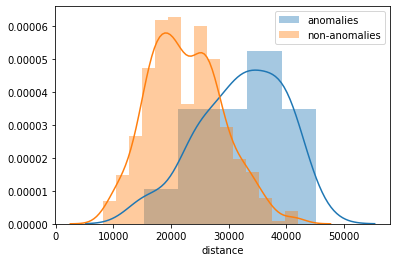

In [23]:
%matplotlib inline
import seaborn as sns
sns.distplot(loss[train_label_mnist].detach().cpu().numpy(), label='anomalies')
sns.distplot(loss[~train_label_mnist].detach().cpu().numpy(), label='non-anomalies')
plt.xlabel('distance')
plt.legend()

## Задание 7 (*)
Попробуйте обучить baseline (классификатор) на большем количестве аномалий. Стал ли классификатор работать лучше AnoGAN и, если да, с какого момента?